# BlackJack : Monte-Carlo with Exploring Start
----

## 설명
블랙잭 게임에서의 최적 Policy를 찾는 프로그램입니다. 본 프로그램에서 정의된 블랙잭 룰은 다음과 같습니다.
 - 하나의 카드 덱(조커를 제외한 52장의 카드)을 사용
 - 카드의 합을 계산할 시 A = 1 or 11, J,Q,K = 10으로 계산
 - 플레이어는 Hit 또는 Stick만을 할 수 있음
 - 카드의 합이 21 이하일 경우, 딜러와 플레이어 중 숫자가 더 높은 쪽이 승리.
 - 카드의 합이 21 초과한 딜러/플레이어는 패배
 - 카드의 합이 같을 경우 무승부

본 프로그램에서는 최적 Policy를 찾기 위해 Monte-Carlo Control with Exploring Start[1] 알고리즘을 사용합니다. 최적 Policy를 찾기 위해, 본 프로그램은 다음과 같은 변수로 구성된 State로부터 탐색을 수행합니다.
 - 플레이어 카드의 합 : 12 ~ 21 사이의 정수
 - 딜러가 보여주는 카드의 숫자 : 1 ~ 10 사이의 정수
 - 플레이어가 현재 사용 가능한 Ace의 유무 : True / False

위와 같이 구성된 State S에서 Action A를 선택했을 때의 기대 리턴(게임이 끝났을 때 얻을 것으로 기대되는 보상의 합)은 Q(S,A)입니다. 많은 에피소드를 경험할수혹 Agent는 Optimal Q(S,A)에 가까운 값을 학습하게 되며, 이로부터 최적 Policy를 찾을 수 있습니다.

----

## 0. Package
먼저 본 프로그램에서 사용할 Package를 Import합니다.

In [18]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

## 1. Class : Deck
카드 덱 한 벌에 해당하는 클래스를 선언합니다. 조커를 제외한 52장의 카드로 이루어져 있으며, 각 카드는 정수로 표기됩니다. <br>
A = 11, J, Q, K = 10으로 표현되며, 나머지 카드는 해당 카드에 적힌 숫자만큼의 값을 갖습니다.

### 클래스 구성
* Attributes
   * card_deck : List, 52개의 정수로 이루어짐
* Methods
   * shuffle() : 카드 덱을 랜덤하게 섞음
   * draw() : 카드 덱에서 한 장을 뽑아 리턴
   * reset() : 카드 덱을 초기화함

In [19]:
class Deck(object):
    """
    Deck : Card deck, which can be shuffled, drawn, and reset.
    """

    def __init__(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.shuffle()

    def shuffle(self):
        random.shuffle(self.card_deck)

    def draw(self):
        return self.card_deck.pop()

    def reset(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.shuffle()

## 2. Class : Dealer
다음으로 Dealer 클래스를 선언합니다.<br> 
Dealer 클래스는 강화학습에서의 Environment에 해당합니다. 플레이어의 Action을 받고, 그에 따른 다음 State와 Reward를 반환합니다.<br>
딜러는 시작할 때 두 장의 카드를 받습니다. 플레이어의 차례가 끝난 후, 플레이어의 카드 합이 21을 넘지 않는다면 딜러는 다음과 같이 행동합니다.
 - 딜러 카드의 합이 17 미만일 때 : 카드 한 장을 추가로 뽑음 (Hit)
 - 딜러 카드의 합이 17 이상일 때 : 플레이어의 카드 합과 비교하여 승패 결정 (Stick)

### 클래스 구성
딜러 클래스는 다음과 같이 구성됩니다
 - Attributes
     - hands : List, 딜러가 가지고 있는 카드들
     - usable_ace : List, 딜러가 가지고 있는 A의 인덱스
 - Methods 
     - hit(deck) : 카드 덱에서 카드 한 장을 뽑아 hands에 추가
     - show() : 딜러가 가진 카드 중 랜덤한 한 장의 값을 리턴
     - calculate_sum() : 딜러가 가진 카드의 합을 리턴. 카드 합이 21 이상일 때 사용 가능한 Ace가 있다면 사용함.
     - action() : 딜러의 Action - 합이 17 미만이면 hit, 이상이면 stick
     - observation(action, agent, deck) : 플레이어의 action을 받아 종료 여부와 reward 리턴
     - calculate_rewards(agent, deck) : 플레이어와 딜러의 승패 계산 및 reward 리턴
     - reset() : 딜러 클래스의 모든 attribute 초기화

In [20]:
class Dealer(object):
    """
    Dealer : 딜러 클래스
    딜러는 두 장의 카드를 받고, 카드의 합이 16 이하이면 Hit, 17이상이면 Stick 함.
    처음 두 장을 받았을 때 한 장의 카드를 랜덤하게 오픈함.
    """

    def __init__(self):
        """
        hand : 딜러가 가진 카드
        usable_ace : 딜러가 가진 카드 리스트 중 ace의 인덱스
        natural : 두 장의 카드로 21이 되면 True, 아니면 False
        """
        self.hands = list()
        self.usable_ace = list()

    def hit(self, deck: Deck):
        """
        딜러의 Hit. 새로운 카드가 Ace라면 사용 가능한 Ace 리스트에 추가함
        :param deck: Deck Object
        :return:
        """
        new_card = deck.draw()
        if new_card == 11:
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)

    def show(self):
        """
        딜러가 가진 카드 중 하나를 랜덤하게 보여줌
        :return: 딜러의 카드 중 랜덤한 카드 숫자
        """
        card = random.choice(self.hands)
        if card == 11:
            card = 1
        return card

    def calculate_sum(self):
        """
        딜러가 가진 카드의 합을 구함
        21을 넘을 때 사용 가능한 Ace가 있으면 사용함
        :return: 딜러 카드의 합
        """
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def action(self, deck: Deck):
        """
        딜러의 순서 때 딜러의 행동.
        숫자의 합이 16 이하일 때는 Hit, 17 이상이면 Stick
        :param deck:
        :return:
        """
        while True:
            sums = self.calculate_sum()
            if sums < 17:
                self.hit(deck)
            else:
                return sums

    def observation(self, action, agent, deck):
        """
        플레이어의 Action을 받아, 그에 맞는 Observation과 Reward를 반환
        :param action: agent 의 Action
        :param agent: agent 클래스
        :param deck: deck 클래스
        :return: 에피소드 종료 여부, reward
        """
        done = False
        reward = 0
        if action == True:  # Hit
            agent.hit(deck)
            if agent.calculate_sum() > 21:  #플레이어의 Hit으로 인해 카드 합이 21이 넘으면 즉시 종료
                done = True
                reward = -1
        else:  # Stick
            done = True
            reward = self.calcuate_reward(agent, deck)

        return done, reward

    def calcuate_reward(self, agent, deck):
        """
        플레이어가 Stick했을 때 딜러와의 카드 비교 수행
        :param agent:
        :param deck:
        :return: Reward
        """
        agent_sum = agent.calculate_sum()           # 플레이어의 카드 합 계산
        if agent_sum > 21:                          # 플레이어의 Bust (패)
            return -1

        dealer_sum = self.action(deck)              # 딜러의 카드 합 계산
        if dealer_sum > 21:                         # 딜러가 Bust (승)
            return 1
        if dealer_sum > agent_sum:                  # 딜러의 카드 합 > 플레이어 합 (패)
            return -1
        if dealer_sum < agent_sum:                  # 딜러의 카드 합 < 플레이어 합 (승)
            return 1
        return 0                                   # 딜러의 카드 합 == 플레이어의 합 (무)

    def reset(self):
        """
        딜러 초기화 (새로운 에피소드 시작을 위해)
        """
        self.hands = list()
        self.usable_ace = list()

## 3. Class : Agent
Agent 클래스는 플레이어에 해당하며, 최적 Policy를 학습하는 주체가 됩니다. Agent는 여러 에피소드들로부터 Q값(기대 Return)을 계산하고, 다음 에피소드 수행 시 해당 State에서 Q값이 높은 Action을 선택하는 Greedy Policy를 따릅니다. 

### 클래스 구성

Agent의 구성은 다음과 같습니다.

 - Attributes
     - hands : List, Agent가 가지고 있는 카드들
     - usable_ace : List, Agent가 가지고 있는 A의 인덱스
     - Q_table : Dictionary, 기대 Return값과 방문 횟수를 저장
 - Methods 
     - hit(deck) : 카드 덱에서 카드 한 장을 뽑아 hands에 추가
     - calculate_sum() : Agent가 가진 카드의 합을 리턴. 카드 합이 21 이상일 때 사용 가능한 Ace가 있다면 사용함.
     - random_action() : 현재 State에 상관없이 랜덤하게 Action을 리턴
     - policy(state) : 현재 State에서 가능한 Action 중, Q_table의 값이 큰 Action을 리턴
     - update_qval(episode) : 에피소드로부터 평균 리턴을 계산하여 Q_table을 업데이트
     - reset() : Agent 클래스의 모든 attribute 초기화

In [21]:
class Agent(object):
    def __init__(self):
        """
        hand : 플레이어의 카드
        usable_ace : 사용 가능한 ace 리스트
        Q_table : q(s,a) 값을 저장할 딕셔너리
        """
        self.hands = list()
        self.usable_ace = list()
        self.Q_table = dict()

    def hit(self, deck: Deck):
        """
        덱에서 새로운 카드를 뽑음
        :param deck: Deck for draw a card
        :return: None
        """
        new_card = deck.draw()
        if new_card == 11:
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)

    def calculate_sum(self):
        """
        플레이어가 가진 카드의 합을 구함.
        21을 넘을 때 사용 가능한 ace가 있으면 사용함
        :return:
        """
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def random_action(self):
        """
        랜덤하게 행동
        True = hit, False = stick
        :return:
        """
        return random.choice([True, False])

    def policy(self, state):
        """
        Agent의 policy 함수.
        e의 확률로 랜덤 행동을 하며, 그 외에는 현재 state에서 큰 q(s,a)값을 갖는 action을 선택함
        :param state: Agent에게 주어진 state
        :return: agent의 action을 반환 , True = hit and False = stick
        """
        # Q_table에서 현재 state-action에 대해 값이 존재하는지 검사함
        for action in (True, False):
            if (state, action) not in self.Q_table.keys():  # Q_table에 값이 없으면 0으로 초기화
                self.Q_table[(state, action)] = [0, 0]      # (mean return, visit count)
            else:
                continue

        # q값이 큰 action 선택
        if self.Q_table[(state, True)] > self.Q_table[(state, False)]:
            return True     # Hit
        elif self.Q_table[(state, True)] == self.Q_table[(state, False)]:   # q값이 같으면 무작위추출
            return self.random_action()
        else:
            return False    # Stick


    def reset(self):
        """
        Agent를 리셋함
        :return: None
        """
        self.hands = list()
        self.usable_ace = list()

    def update_qval(self, episode):
        """
        에피소드(한 번의 게임)으로부터 Q_table 을 업데이트함
        Q 테이블에 없는 state-action 쌍이 나오면 새로 생성
        Q 테이블에 state-action 쌍이 존재한다면 Incremental mean 적용하여 업데이트
        :param episode: Episode generated from environment
        :return: None
        """
        total_return = 0
        for state, action, reward in episode[::-1]:     # 에피소드의 뒤에서부터 (역순)
            total_return += reward                       # return Gt 계산
            if (state, action) not in self.Q_table.keys():  # state-action 쌍이 없다면
                self.Q_table[(state, action)] = [total_return, 1]   # 새롭게 엔트리 생성 (Gt, count)

            else:  #이미 존재하는 state-action 쌍이면 Incremental mean 적용
                prev_val = self.Q_table[(state, action)][0]         # 이전의 평균 return
                count = self.Q_table[(state, action)][1] + 1        # count 증가
                mean = prev_val + (total_return - prev_val) / count # 평균 계산 : Incremental Mean 적용
                self.Q_table[(state, action)] = [mean, count]  # 업데이트

## 4. Class : MonteCarlo
Monte-Carlo control with Exploring Start를 구현한 클래스입니다. 에피소드를 생성할 수 있고, 생성된 에피소드로부터 에이전트를 학습시킵니다.
에피소드 생성 시 Exploring Start를 위해 에피소드의 첫 번째 State에서는 무작위로 Action을 선택하며, 이후에는 에이전트의 Policy를 따라 Action을 선택합니다.

### 클래스 구성
MonteCarlo 클래스는 다음과 같이 구성됩니다.
 - Attribute
     - 없음
 - Methods 
     - generate_episode(dealer, agent, deck) : 딜러, 플레이어, 카드 덱을 이용해 한 번의 블랙잭 게임을 진행하고 에피소드를 반환합니다.
     - train(dealer, agent, deck, it, verbose) : 지정된 이터레이션 수만큼의 에피소드로부터 플레이어를 학습시킵니다.

In [22]:
class MonteCarlo(object):
    def generate_episode(self, dealer: Dealer, agent: Agent, deck: Deck):
        """
        하나의 에피소드(게임)를 생성함
        :param dealer:
        :param agent:
        :param deck:
        :return:
        """
        
        # 카드 덱, 딜러, Agent를 초기화
        deck.reset()
        dealer.reset()
        agent.reset()
        agent.hit(deck)
        agent.hit(deck)
        dealer.hit(deck)
        dealer.hit(deck)

        done = False    # 에피소드의 종료 여부

        episode = list()    # 에피소드

        while not done:
            # 에피소드가 끝날 때까지 State, Action, Reward를 생성
            sums = agent.calculate_sum()
            if sums < 12:
                agent.hit(deck)
                continue

            state = (sums, bool(agent.usable_ace), dealer.show())

            ########   Exploring Start ~!!!!!!!!! : 
            if len(episode) == 0:       # 첫번째 State 일 때는 무작위 Action 선택
                action =agent.random_action()
            else:                       # 그 외에는 Q 테이블에서 큰 값을 갖는 Action 선택
                action = agent.policy(state)
            
            done, reward = dealer.observation(action, agent, deck)  # 에피소드 종료 여부, Reward 계산
            
            # 생성된 State, Action, Reward를 에피소드에 추가
            episode.append([state, action, reward])

        return episode

    def train(self, dealer: Dealer, agent: Agent, deck: Deck, it=10000, verbose=True):
        count = 0
        win = 0
        loss = 0
        draw = 0
        total_win = 0
        total_loss = 0
        total_draw = 0
        result = str()
        for i in range(it):
            count += 1
            episode = self.generate_episode(dealer, agent, deck)
            agent.update_qval(episode)

            if episode[-1][-1] == 1:
                win += 1
            elif episode[-1][-1] == 0:
                draw += 1
            else:
                loss += 1

            if count % 1000 == 0 and verbose == True:
                total_win += win
                total_loss += loss
                total_draw += draw

                print("========== Training : Episode ", count, " ===========")
                print("Recent 1000 games win rate :{:.3f}%".format(win / (win + loss) * 100))
                print(" -- 1000 Games WIN :", win, "DRAW :", draw, "LOSS :", loss)
                print("Total win rate : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
                print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)

                win = 0
                loss = 0
                draw = 0
                

## 5. Function : plot_q_val(agent, usable_ace)
Q값을 시각화하기 위한 함수입니다.

In [23]:
def plot_q_val(agent: Agent, usable_ace=True):
    fig = plt.figure()
    ax = Axes3D(fig)

    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            v_val = max([agent.Q_table[((hand, usable_ace, d), True)][0], agent.Q_table[((hand, usable_ace, d), False)][0]])
            l.append(v_val)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)

    Z = np.array(Z_list).T

    ax.plot_wireframe(X, Y, Z)
    plt.show()

## 6. Function : plot_q_val(agent, usable_ace)
최적 Policy를 시각화하기 위한 함수입니다.

In [24]:
def plot_action(agent: Agent, usable_ace=True):
    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    action = False

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            l.append(0 if agent.Q_table[((hand, usable_ace, d), True)][0] > agent.Q_table[((hand, usable_ace, d), False)][0] else 1)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)
    Z = np.array(Z_list).T

    data = Z[::-1,:]
    data = np.append(data, [0 for _ in range(Z[0].shape[0])]).reshape(-1,Z[0].shape[0])
    
    cmap=cm.coolwarm
    plt.imshow(data, cmap=cmap, extent=[1,11,11,21])

    plt.show()
    return X, Y, Z

## 7. 최적 Policy 학습


In [25]:
deck = Deck()
dealer = Dealer()
agent = Agent()
mc_es = MonteCarlo()

mc_es.train(dealer, agent, deck, it=1000000)

========== Training : Episode  1000  ===========
Recent 1000 games win rate :34.036%
 -- 1000 Games WIN : 323 DRAW : 51 LOSS : 626
Total win rate : 34.036%
 -- TOTAL Games WIN : 323 DRAW : 51 LOSS : 626
========== Training : Episode  2000  ===========
Recent 1000 games win rate :35.161%
 -- 1000 Games WIN : 327 DRAW : 70 LOSS : 603
Total win rate : 34.593%
 -- TOTAL Games WIN : 650 DRAW : 121 LOSS : 1229
========== Training : Episode  3000  ===========
Recent 1000 games win rate :35.579%
 -- 1000 Games WIN : 338 DRAW : 50 LOSS : 612
Total win rate : 34.924%
 -- TOTAL Games WIN : 988 DRAW : 171 LOSS : 1841
========== Training : Episode  4000  ===========
Recent 1000 games win rate :37.942%
 -- 1000 Games WIN : 354 DRAW : 67 LOSS : 579
Total win rate : 35.673%
 -- TOTAL Games WIN : 1342 DRAW : 238 LOSS : 2420
========== Training : Episode  5000  ===========
Recent 1000 games win rate :35.086%
 -- 1000 Games WIN : 327 DRAW : 68 LOSS : 605
Total win rate : 35.556%
 -- TOTAL Games WIN : 166

========== Training : Episode  41000  ===========
Recent 1000 games win rate :36.876%
 -- 1000 Games WIN : 347 DRAW : 59 LOSS : 594
Total win rate : 35.084%
 -- TOTAL Games WIN : 13524 DRAW : 2453 LOSS : 25023
========== Training : Episode  42000  ===========
Recent 1000 games win rate :36.141%
 -- 1000 Games WIN : 339 DRAW : 62 LOSS : 599
Total win rate : 35.110%
 -- TOTAL Games WIN : 13863 DRAW : 2515 LOSS : 25622
========== Training : Episode  43000  ===========
Recent 1000 games win rate :34.632%
 -- 1000 Games WIN : 329 DRAW : 50 LOSS : 621
Total win rate : 35.098%
 -- TOTAL Games WIN : 14192 DRAW : 2565 LOSS : 26243
========== Training : Episode  44000  ===========
Recent 1000 games win rate :34.984%
 -- 1000 Games WIN : 325 DRAW : 71 LOSS : 604
Total win rate : 35.096%
 -- TOTAL Games WIN : 14517 DRAW : 2636 LOSS : 26847
========== Training : Episode  45000  ===========
Recent 1000 games win rate :37.021%
 -- 1000 Games WIN : 348 DRAW : 60 LOSS : 592
Total win rate : 35.139%
 --

========== Training : Episode  84000  ===========
Recent 1000 games win rate :35.370%
 -- 1000 Games WIN : 330 DRAW : 67 LOSS : 603
Total win rate : 35.406%
 -- TOTAL Games WIN : 27930 DRAW : 5115 LOSS : 50955
========== Training : Episode  85000  ===========
Recent 1000 games win rate :35.714%
 -- 1000 Games WIN : 335 DRAW : 62 LOSS : 603
Total win rate : 35.410%
 -- TOTAL Games WIN : 28265 DRAW : 5177 LOSS : 51558
========== Training : Episode  86000  ===========
Recent 1000 games win rate :32.484%
 -- 1000 Games WIN : 306 DRAW : 58 LOSS : 636
Total win rate : 35.375%
 -- TOTAL Games WIN : 28571 DRAW : 5235 LOSS : 52194
========== Training : Episode  87000  ===========
Recent 1000 games win rate :34.252%
 -- 1000 Games WIN : 323 DRAW : 57 LOSS : 620
Total win rate : 35.363%
 -- TOTAL Games WIN : 28894 DRAW : 5292 LOSS : 52814
========== Training : Episode  88000  ===========
Recent 1000 games win rate :35.307%
 -- 1000 Games WIN : 328 DRAW : 71 LOSS : 601
Total win rate : 35.362%
 --

========== Training : Episode  125000  ===========
Recent 1000 games win rate :35.504%
 -- 1000 Games WIN : 338 DRAW : 48 LOSS : 614
Total win rate : 35.338%
 -- TOTAL Games WIN : 41517 DRAW : 7516 LOSS : 75967
========== Training : Episode  126000  ===========
Recent 1000 games win rate :32.760%
 -- 1000 Games WIN : 305 DRAW : 69 LOSS : 626
Total win rate : 35.318%
 -- TOTAL Games WIN : 41822 DRAW : 7585 LOSS : 76593
========== Training : Episode  127000  ===========
Recent 1000 games win rate :37.696%
 -- 1000 Games WIN : 360 DRAW : 45 LOSS : 595
Total win rate : 35.337%
 -- TOTAL Games WIN : 42182 DRAW : 7630 LOSS : 77188
========== Training : Episode  128000  ===========
Recent 1000 games win rate :35.363%
 -- 1000 Games WIN : 331 DRAW : 64 LOSS : 605
Total win rate : 35.337%
 -- TOTAL Games WIN : 42513 DRAW : 7694 LOSS : 77793
========== Training : Episode  129000  ===========
Recent 1000 games win rate :35.859%
 -- 1000 Games WIN : 336 DRAW : 63 LOSS : 601
Total win rate : 35.341

========== Training : Episode  166000  ===========
Recent 1000 games win rate :35.570%
 -- 1000 Games WIN : 334 DRAW : 61 LOSS : 605
Total win rate : 35.330%
 -- TOTAL Games WIN : 55121 DRAW : 9983 LOSS : 100896
========== Training : Episode  167000  ===========
Recent 1000 games win rate :34.806%
 -- 1000 Games WIN : 323 DRAW : 72 LOSS : 605
Total win rate : 35.327%
 -- TOTAL Games WIN : 55444 DRAW : 10055 LOSS : 101501
========== Training : Episode  168000  ===========
Recent 1000 games win rate :35.692%
 -- 1000 Games WIN : 338 DRAW : 53 LOSS : 609
Total win rate : 35.329%
 -- TOTAL Games WIN : 55782 DRAW : 10108 LOSS : 102110
========== Training : Episode  169000  ===========
Recent 1000 games win rate :34.926%
 -- 1000 Games WIN : 329 DRAW : 58 LOSS : 613
Total win rate : 35.327%
 -- TOTAL Games WIN : 56111 DRAW : 10166 LOSS : 102723
========== Training : Episode  170000  ===========
Recent 1000 games win rate :35.138%
 -- 1000 Games WIN : 331 DRAW : 58 LOSS : 611
Total win rate :

========== Training : Episode  205000  ===========
Recent 1000 games win rate :36.479%
 -- 1000 Games WIN : 344 DRAW : 57 LOSS : 599
Total win rate : 35.349%
 -- TOTAL Games WIN : 68130 DRAW : 12263 LOSS : 124607
========== Training : Episode  206000  ===========
Recent 1000 games win rate :34.295%
 -- 1000 Games WIN : 321 DRAW : 64 LOSS : 615
Total win rate : 35.344%
 -- TOTAL Games WIN : 68451 DRAW : 12327 LOSS : 125222
========== Training : Episode  207000  ===========
Recent 1000 games win rate :34.352%
 -- 1000 Games WIN : 326 DRAW : 51 LOSS : 623
Total win rate : 35.339%
 -- TOTAL Games WIN : 68777 DRAW : 12378 LOSS : 125845
========== Training : Episode  208000  ===========
Recent 1000 games win rate :37.619%
 -- 1000 Games WIN : 357 DRAW : 51 LOSS : 592
Total win rate : 35.350%
 -- TOTAL Games WIN : 69134 DRAW : 12429 LOSS : 126437
========== Training : Episode  209000  ===========
Recent 1000 games win rate :34.746%
 -- 1000 Games WIN : 328 DRAW : 56 LOSS : 616
Total win rate 

========== Training : Episode  244000  ===========
Recent 1000 games win rate :36.052%
 -- 1000 Games WIN : 336 DRAW : 68 LOSS : 596
Total win rate : 35.387%
 -- TOTAL Games WIN : 81217 DRAW : 14490 LOSS : 148293
========== Training : Episode  245000  ===========
Recent 1000 games win rate :37.366%
 -- 1000 Games WIN : 349 DRAW : 66 LOSS : 585
Total win rate : 35.395%
 -- TOTAL Games WIN : 81566 DRAW : 14556 LOSS : 148878
========== Training : Episode  246000  ===========
Recent 1000 games win rate :36.076%
 -- 1000 Games WIN : 342 DRAW : 52 LOSS : 606
Total win rate : 35.398%
 -- TOTAL Games WIN : 81908 DRAW : 14608 LOSS : 149484
========== Training : Episode  247000  ===========
Recent 1000 games win rate :33.653%
 -- 1000 Games WIN : 316 DRAW : 61 LOSS : 623
Total win rate : 35.391%
 -- TOTAL Games WIN : 82224 DRAW : 14669 LOSS : 150107
========== Training : Episode  248000  ===========
Recent 1000 games win rate :33.404%
 -- 1000 Games WIN : 316 DRAW : 54 LOSS : 630
Total win rate 

========== Training : Episode  288000  ===========
Recent 1000 games win rate :37.367%
 -- 1000 Games WIN : 352 DRAW : 58 LOSS : 590
Total win rate : 35.419%
 -- TOTAL Games WIN : 95951 DRAW : 17094 LOSS : 174955
========== Training : Episode  289000  ===========
Recent 1000 games win rate :36.528%
 -- 1000 Games WIN : 343 DRAW : 61 LOSS : 596
Total win rate : 35.422%
 -- TOTAL Games WIN : 96294 DRAW : 17155 LOSS : 175551
========== Training : Episode  290000  ===========
Recent 1000 games win rate :32.875%
 -- 1000 Games WIN : 311 DRAW : 54 LOSS : 635
Total win rate : 35.414%
 -- TOTAL Games WIN : 96605 DRAW : 17209 LOSS : 176186
========== Training : Episode  291000  ===========
Recent 1000 games win rate :37.540%
 -- 1000 Games WIN : 348 DRAW : 73 LOSS : 579
Total win rate : 35.421%
 -- TOTAL Games WIN : 96953 DRAW : 17282 LOSS : 176765
========== Training : Episode  292000  ===========
Recent 1000 games win rate :34.483%
 -- 1000 Games WIN : 320 DRAW : 72 LOSS : 608
Total win rate 

========== Training : Episode  327000  ===========
Recent 1000 games win rate :33.333%
 -- 1000 Games WIN : 316 DRAW : 52 LOSS : 632
Total win rate : 35.424%
 -- TOTAL Games WIN : 108964 DRAW : 19398 LOSS : 198638
========== Training : Episode  328000  ===========
Recent 1000 games win rate :38.527%
 -- 1000 Games WIN : 361 DRAW : 63 LOSS : 576
Total win rate : 35.433%
 -- TOTAL Games WIN : 109325 DRAW : 19461 LOSS : 199214
========== Training : Episode  329000  ===========
Recent 1000 games win rate :38.176%
 -- 1000 Games WIN : 360 DRAW : 57 LOSS : 583
Total win rate : 35.441%
 -- TOTAL Games WIN : 109685 DRAW : 19518 LOSS : 199797
========== Training : Episode  330000  ===========
Recent 1000 games win rate :36.632%
 -- 1000 Games WIN : 348 DRAW : 50 LOSS : 602
Total win rate : 35.445%
 -- TOTAL Games WIN : 110033 DRAW : 19568 LOSS : 200399
========== Training : Episode  331000  ===========
Recent 1000 games win rate :34.567%
 -- 1000 Games WIN : 327 DRAW : 54 LOSS : 619
Total win r

========== Training : Episode  369000  ===========
Recent 1000 games win rate :34.076%
 -- 1000 Games WIN : 321 DRAW : 58 LOSS : 621
Total win rate : 35.402%
 -- TOTAL Games WIN : 122880 DRAW : 21899 LOSS : 224221
========== Training : Episode  370000  ===========
Recent 1000 games win rate :36.249%
 -- 1000 Games WIN : 344 DRAW : 51 LOSS : 605
Total win rate : 35.404%
 -- TOTAL Games WIN : 123224 DRAW : 21950 LOSS : 224826
========== Training : Episode  371000  ===========
Recent 1000 games win rate :36.413%
 -- 1000 Games WIN : 335 DRAW : 80 LOSS : 585
Total win rate : 35.407%
 -- TOTAL Games WIN : 123559 DRAW : 22030 LOSS : 225411
========== Training : Episode  372000  ===========
Recent 1000 games win rate :35.914%
 -- 1000 Games WIN : 334 DRAW : 70 LOSS : 596
Total win rate : 35.408%
 -- TOTAL Games WIN : 123893 DRAW : 22100 LOSS : 226007
========== Training : Episode  373000  ===========
Recent 1000 games win rate :36.950%
 -- 1000 Games WIN : 344 DRAW : 69 LOSS : 587
Total win r

========== Training : Episode  409000  ===========
Recent 1000 games win rate :34.661%
 -- 1000 Games WIN : 322 DRAW : 71 LOSS : 607
Total win rate : 35.411%
 -- TOTAL Games WIN : 136207 DRAW : 24352 LOSS : 248441
========== Training : Episode  410000  ===========
Recent 1000 games win rate :35.498%
 -- 1000 Games WIN : 328 DRAW : 76 LOSS : 596
Total win rate : 35.411%
 -- TOTAL Games WIN : 136535 DRAW : 24428 LOSS : 249037
========== Training : Episode  411000  ===========
Recent 1000 games win rate :33.476%
 -- 1000 Games WIN : 313 DRAW : 65 LOSS : 622
Total win rate : 35.406%
 -- TOTAL Games WIN : 136848 DRAW : 24493 LOSS : 249659
========== Training : Episode  412000  ===========
Recent 1000 games win rate :36.141%
 -- 1000 Games WIN : 339 DRAW : 62 LOSS : 599
Total win rate : 35.408%
 -- TOTAL Games WIN : 137187 DRAW : 24555 LOSS : 250258
========== Training : Episode  413000  ===========
Recent 1000 games win rate :34.424%
 -- 1000 Games WIN : 326 DRAW : 53 LOSS : 621
Total win r

========== Training : Episode  452000  ===========
Recent 1000 games win rate :34.188%
 -- 1000 Games WIN : 320 DRAW : 64 LOSS : 616
Total win rate : 35.401%
 -- TOTAL Games WIN : 150464 DRAW : 26971 LOSS : 274565
========== Training : Episode  453000  ===========
Recent 1000 games win rate :36.017%
 -- 1000 Games WIN : 340 DRAW : 56 LOSS : 604
Total win rate : 35.402%
 -- TOTAL Games WIN : 150804 DRAW : 27027 LOSS : 275169
========== Training : Episode  454000  ===========
Recent 1000 games win rate :35.653%
 -- 1000 Games WIN : 333 DRAW : 66 LOSS : 601
Total win rate : 35.403%
 -- TOTAL Games WIN : 151137 DRAW : 27093 LOSS : 275770
========== Training : Episode  455000  ===========
Recent 1000 games win rate :36.938%
 -- 1000 Games WIN : 345 DRAW : 66 LOSS : 589
Total win rate : 35.406%
 -- TOTAL Games WIN : 151482 DRAW : 27159 LOSS : 276359
========== Training : Episode  456000  ===========
Recent 1000 games win rate :35.408%
 -- 1000 Games WIN : 330 DRAW : 68 LOSS : 602
Total win r

========== Training : Episode  494000  ===========
Recent 1000 games win rate :36.000%
 -- 1000 Games WIN : 333 DRAW : 75 LOSS : 592
Total win rate : 35.403%
 -- TOTAL Games WIN : 164436 DRAW : 29537 LOSS : 300027
========== Training : Episode  495000  ===========
Recent 1000 games win rate :36.469%
 -- 1000 Games WIN : 345 DRAW : 54 LOSS : 601
Total win rate : 35.406%
 -- TOTAL Games WIN : 164781 DRAW : 29591 LOSS : 300628
========== Training : Episode  496000  ===========
Recent 1000 games win rate :35.873%
 -- 1000 Games WIN : 339 DRAW : 55 LOSS : 606
Total win rate : 35.407%
 -- TOTAL Games WIN : 165120 DRAW : 29646 LOSS : 301234
========== Training : Episode  497000  ===========
Recent 1000 games win rate :34.128%
 -- 1000 Games WIN : 315 DRAW : 77 LOSS : 608
Total win rate : 35.404%
 -- TOTAL Games WIN : 165435 DRAW : 29723 LOSS : 301842
========== Training : Episode  498000  ===========
Recent 1000 games win rate :37.106%
 -- 1000 Games WIN : 341 DRAW : 81 LOSS : 578
Total win r

========== Training : Episode  533000  ===========
Recent 1000 games win rate :35.144%
 -- 1000 Games WIN : 330 DRAW : 61 LOSS : 609
Total win rate : 35.405%
 -- TOTAL Games WIN : 177412 DRAW : 31911 LOSS : 323677
========== Training : Episode  534000  ===========
Recent 1000 games win rate :35.549%
 -- 1000 Games WIN : 337 DRAW : 52 LOSS : 611
Total win rate : 35.406%
 -- TOTAL Games WIN : 177749 DRAW : 31963 LOSS : 324288
========== Training : Episode  535000  ===========
Recent 1000 games win rate :35.474%
 -- 1000 Games WIN : 337 DRAW : 50 LOSS : 613
Total win rate : 35.406%
 -- TOTAL Games WIN : 178086 DRAW : 32013 LOSS : 324901
========== Training : Episode  536000  ===========
Recent 1000 games win rate :35.579%
 -- 1000 Games WIN : 338 DRAW : 50 LOSS : 612
Total win rate : 35.406%
 -- TOTAL Games WIN : 178424 DRAW : 32063 LOSS : 325513
========== Training : Episode  537000  ===========
Recent 1000 games win rate :35.453%
 -- 1000 Games WIN : 329 DRAW : 72 LOSS : 599
Total win r

========== Training : Episode  575000  ===========
Recent 1000 games win rate :36.055%
 -- 1000 Games WIN : 340 DRAW : 57 LOSS : 603
Total win rate : 35.410%
 -- TOTAL Games WIN : 191395 DRAW : 34483 LOSS : 349122
========== Training : Episode  576000  ===========
Recent 1000 games win rate :34.149%
 -- 1000 Games WIN : 321 DRAW : 60 LOSS : 619
Total win rate : 35.407%
 -- TOTAL Games WIN : 191716 DRAW : 34543 LOSS : 349741
========== Training : Episode  577000  ===========
Recent 1000 games win rate :35.432%
 -- 1000 Games WIN : 332 DRAW : 63 LOSS : 605
Total win rate : 35.407%
 -- TOTAL Games WIN : 192048 DRAW : 34606 LOSS : 350346
========== Training : Episode  578000  ===========
Recent 1000 games win rate :34.139%
 -- 1000 Games WIN : 325 DRAW : 48 LOSS : 627
Total win rate : 35.405%
 -- TOTAL Games WIN : 192373 DRAW : 34654 LOSS : 350973
========== Training : Episode  579000  ===========
Recent 1000 games win rate :36.820%
 -- 1000 Games WIN : 345 DRAW : 63 LOSS : 592
Total win r

========== Training : Episode  616000  ===========
Recent 1000 games win rate :38.024%
 -- 1000 Games WIN : 354 DRAW : 69 LOSS : 577
Total win rate : 35.428%
 -- TOTAL Games WIN : 205140 DRAW : 36963 LOSS : 373897
========== Training : Episode  617000  ===========
Recent 1000 games win rate :38.182%
 -- 1000 Games WIN : 357 DRAW : 65 LOSS : 578
Total win rate : 35.432%
 -- TOTAL Games WIN : 205497 DRAW : 37028 LOSS : 374475
========== Training : Episode  618000  ===========
Recent 1000 games win rate :37.088%
 -- 1000 Games WIN : 349 DRAW : 59 LOSS : 592
Total win rate : 35.435%
 -- TOTAL Games WIN : 205846 DRAW : 37087 LOSS : 375067
========== Training : Episode  619000  ===========
Recent 1000 games win rate :35.827%
 -- 1000 Games WIN : 340 DRAW : 51 LOSS : 609
Total win rate : 35.436%
 -- TOTAL Games WIN : 206186 DRAW : 37138 LOSS : 375676
========== Training : Episode  620000  ===========
Recent 1000 games win rate :38.641%
 -- 1000 Games WIN : 364 DRAW : 58 LOSS : 578
Total win r

========== Training : Episode  657000  ===========
Recent 1000 games win rate :35.593%
 -- 1000 Games WIN : 336 DRAW : 56 LOSS : 608
Total win rate : 35.481%
 -- TOTAL Games WIN : 219126 DRAW : 39412 LOSS : 398462
========== Training : Episode  658000  ===========
Recent 1000 games win rate :35.730%
 -- 1000 Games WIN : 333 DRAW : 68 LOSS : 599
Total win rate : 35.481%
 -- TOTAL Games WIN : 219459 DRAW : 39480 LOSS : 399061
========== Training : Episode  659000  ===========
Recent 1000 games win rate :34.319%
 -- 1000 Games WIN : 325 DRAW : 53 LOSS : 622
Total win rate : 35.480%
 -- TOTAL Games WIN : 219784 DRAW : 39533 LOSS : 399683
========== Training : Episode  660000  ===========
Recent 1000 games win rate :38.273%
 -- 1000 Games WIN : 359 DRAW : 62 LOSS : 579
Total win rate : 35.484%
 -- TOTAL Games WIN : 220143 DRAW : 39595 LOSS : 400262
========== Training : Episode  661000  ===========
Recent 1000 games win rate :37.750%
 -- 1000 Games WIN : 359 DRAW : 49 LOSS : 592
Total win r

========== Training : Episode  696000  ===========
Recent 1000 games win rate :36.325%
 -- 1000 Games WIN : 344 DRAW : 53 LOSS : 603
Total win rate : 35.494%
 -- TOTAL Games WIN : 232194 DRAW : 41829 LOSS : 421977
========== Training : Episode  697000  ===========
Recent 1000 games win rate :35.344%
 -- 1000 Games WIN : 334 DRAW : 55 LOSS : 611
Total win rate : 35.494%
 -- TOTAL Games WIN : 232528 DRAW : 41884 LOSS : 422588
========== Training : Episode  698000  ===========
Recent 1000 games win rate :34.769%
 -- 1000 Games WIN : 331 DRAW : 48 LOSS : 621
Total win rate : 35.493%
 -- TOTAL Games WIN : 232859 DRAW : 41932 LOSS : 423209
========== Training : Episode  699000  ===========
Recent 1000 games win rate :35.622%
 -- 1000 Games WIN : 332 DRAW : 68 LOSS : 600
Total win rate : 35.493%
 -- TOTAL Games WIN : 233191 DRAW : 42000 LOSS : 423809
========== Training : Episode  700000  ===========
Recent 1000 games win rate :36.008%
 -- 1000 Games WIN : 341 DRAW : 53 LOSS : 606
Total win r

========== Training : Episode  738000  ===========
Recent 1000 games win rate :36.105%
 -- 1000 Games WIN : 343 DRAW : 50 LOSS : 607
Total win rate : 35.489%
 -- TOTAL Games WIN : 246182 DRAW : 44314 LOSS : 447504
========== Training : Episode  739000  ===========
Recent 1000 games win rate :33.827%
 -- 1000 Games WIN : 320 DRAW : 54 LOSS : 626
Total win rate : 35.487%
 -- TOTAL Games WIN : 246502 DRAW : 44368 LOSS : 448130
========== Training : Episode  740000  ===========
Recent 1000 games win rate :34.632%
 -- 1000 Games WIN : 320 DRAW : 76 LOSS : 604
Total win rate : 35.486%
 -- TOTAL Games WIN : 246822 DRAW : 44444 LOSS : 448734
========== Training : Episode  741000  ===========
Recent 1000 games win rate :36.688%
 -- 1000 Games WIN : 339 DRAW : 76 LOSS : 585
Total win rate : 35.487%
 -- TOTAL Games WIN : 247161 DRAW : 44520 LOSS : 449319
========== Training : Episode  742000  ===========
Recent 1000 games win rate :36.528%
 -- 1000 Games WIN : 343 DRAW : 61 LOSS : 596
Total win r

========== Training : Episode  780000  ===========
Recent 1000 games win rate :35.608%
 -- 1000 Games WIN : 334 DRAW : 62 LOSS : 604
Total win rate : 35.474%
 -- TOTAL Games WIN : 260079 DRAW : 46849 LOSS : 473072
========== Training : Episode  781000  ===========
Recent 1000 games win rate :35.097%
 -- 1000 Games WIN : 325 DRAW : 74 LOSS : 601
Total win rate : 35.474%
 -- TOTAL Games WIN : 260404 DRAW : 46923 LOSS : 473673
========== Training : Episode  782000  ===========
Recent 1000 games win rate :38.519%
 -- 1000 Games WIN : 364 DRAW : 55 LOSS : 581
Total win rate : 35.478%
 -- TOTAL Games WIN : 260768 DRAW : 46978 LOSS : 474254
========== Training : Episode  783000  ===========
Recent 1000 games win rate :32.347%
 -- 1000 Games WIN : 306 DRAW : 54 LOSS : 640
Total win rate : 35.474%
 -- TOTAL Games WIN : 261074 DRAW : 47032 LOSS : 474894
========== Training : Episode  784000  ===========
Recent 1000 games win rate :33.512%
 -- 1000 Games WIN : 313 DRAW : 66 LOSS : 621
Total win r

========== Training : Episode  821000  ===========
Recent 1000 games win rate :35.394%
 -- 1000 Games WIN : 332 DRAW : 62 LOSS : 606
Total win rate : 35.485%
 -- TOTAL Games WIN : 273850 DRAW : 49266 LOSS : 497884
========== Training : Episode  822000  ===========
Recent 1000 games win rate :33.085%
 -- 1000 Games WIN : 311 DRAW : 60 LOSS : 629
Total win rate : 35.482%
 -- TOTAL Games WIN : 274161 DRAW : 49326 LOSS : 498513
========== Training : Episode  823000  ===========
Recent 1000 games win rate :33.439%
 -- 1000 Games WIN : 317 DRAW : 52 LOSS : 631
Total win rate : 35.480%
 -- TOTAL Games WIN : 274478 DRAW : 49378 LOSS : 499144
========== Training : Episode  824000  ===========
Recent 1000 games win rate :34.222%
 -- 1000 Games WIN : 321 DRAW : 62 LOSS : 617
Total win rate : 35.478%
 -- TOTAL Games WIN : 274799 DRAW : 49440 LOSS : 499761
========== Training : Episode  825000  ===========
Recent 1000 games win rate :33.652%
 -- 1000 Games WIN : 317 DRAW : 58 LOSS : 625
Total win r

========== Training : Episode  863000  ===========
Recent 1000 games win rate :35.851%
 -- 1000 Games WIN : 337 DRAW : 60 LOSS : 603
Total win rate : 35.470%
 -- TOTAL Games WIN : 287743 DRAW : 51765 LOSS : 523492
========== Training : Episode  864000  ===========
Recent 1000 games win rate :37.500%
 -- 1000 Games WIN : 348 DRAW : 72 LOSS : 580
Total win rate : 35.472%
 -- TOTAL Games WIN : 288091 DRAW : 51837 LOSS : 524072
========== Training : Episode  865000  ===========
Recent 1000 games win rate :35.439%
 -- 1000 Games WIN : 331 DRAW : 66 LOSS : 603
Total win rate : 35.472%
 -- TOTAL Games WIN : 288422 DRAW : 51903 LOSS : 524675
========== Training : Episode  866000  ===========
Recent 1000 games win rate :31.499%
 -- 1000 Games WIN : 292 DRAW : 73 LOSS : 635
Total win rate : 35.468%
 -- TOTAL Games WIN : 288714 DRAW : 51976 LOSS : 525310
========== Training : Episode  867000  ===========
Recent 1000 games win rate :35.979%
 -- 1000 Games WIN : 340 DRAW : 55 LOSS : 605
Total win r

========== Training : Episode  904000  ===========
Recent 1000 games win rate :39.679%
 -- 1000 Games WIN : 371 DRAW : 65 LOSS : 564
Total win rate : 35.479%
 -- TOTAL Games WIN : 301482 DRAW : 54247 LOSS : 548271
========== Training : Episode  905000  ===========
Recent 1000 games win rate :34.446%
 -- 1000 Games WIN : 320 DRAW : 71 LOSS : 609
Total win rate : 35.478%
 -- TOTAL Games WIN : 301802 DRAW : 54318 LOSS : 548880
========== Training : Episode  906000  ===========
Recent 1000 games win rate :35.661%
 -- 1000 Games WIN : 337 DRAW : 55 LOSS : 608
Total win rate : 35.478%
 -- TOTAL Games WIN : 302139 DRAW : 54373 LOSS : 549488
========== Training : Episode  907000  ===========
Recent 1000 games win rate :35.684%
 -- 1000 Games WIN : 334 DRAW : 64 LOSS : 602
Total win rate : 35.478%
 -- TOTAL Games WIN : 302473 DRAW : 54437 LOSS : 550090
========== Training : Episode  908000  ===========
Recent 1000 games win rate :35.032%
 -- 1000 Games WIN : 330 DRAW : 58 LOSS : 612
Total win r

========== Training : Episode  947000  ===========
Recent 1000 games win rate :34.919%
 -- 1000 Games WIN : 323 DRAW : 75 LOSS : 602
Total win rate : 35.477%
 -- TOTAL Games WIN : 315821 DRAW : 56784 LOSS : 574395
========== Training : Episode  948000  ===========
Recent 1000 games win rate :37.364%
 -- 1000 Games WIN : 343 DRAW : 82 LOSS : 575
Total win rate : 35.479%
 -- TOTAL Games WIN : 316164 DRAW : 56866 LOSS : 574970
========== Training : Episode  949000  ===========
Recent 1000 games win rate :34.627%
 -- 1000 Games WIN : 330 DRAW : 47 LOSS : 623
Total win rate : 35.478%
 -- TOTAL Games WIN : 316494 DRAW : 56913 LOSS : 575593
========== Training : Episode  950000  ===========
Recent 1000 games win rate :37.128%
 -- 1000 Games WIN : 349 DRAW : 60 LOSS : 591
Total win rate : 35.480%
 -- TOTAL Games WIN : 316843 DRAW : 56973 LOSS : 576184
========== Training : Episode  951000  ===========
Recent 1000 games win rate :35.638%
 -- 1000 Games WIN : 335 DRAW : 60 LOSS : 605
Total win r

========== Training : Episode  987000  ===========
Recent 1000 games win rate :34.516%
 -- 1000 Games WIN : 321 DRAW : 70 LOSS : 609
Total win rate : 35.476%
 -- TOTAL Games WIN : 329157 DRAW : 59167 LOSS : 598676
========== Training : Episode  988000  ===========
Recent 1000 games win rate :33.768%
 -- 1000 Games WIN : 311 DRAW : 79 LOSS : 610
Total win rate : 35.474%
 -- TOTAL Games WIN : 329468 DRAW : 59246 LOSS : 599286
========== Training : Episode  989000  ===========
Recent 1000 games win rate :34.115%
 -- 1000 Games WIN : 320 DRAW : 62 LOSS : 618
Total win rate : 35.473%
 -- TOTAL Games WIN : 329788 DRAW : 59308 LOSS : 599904
========== Training : Episode  990000  ===========
Recent 1000 games win rate :35.821%
 -- 1000 Games WIN : 336 DRAW : 62 LOSS : 602
Total win rate : 35.473%
 -- TOTAL Games WIN : 330124 DRAW : 59370 LOSS : 600506
========== Training : Episode  991000  ===========
Recent 1000 games win rate :34.861%
 -- 1000 Games WIN : 327 DRAW : 62 LOSS : 611
Total win r

## 8. 학습 결과 시각화

Q-value with Usable Ace


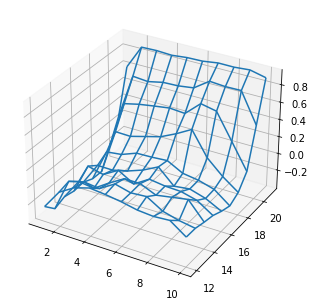

Q-value without Usable Ace


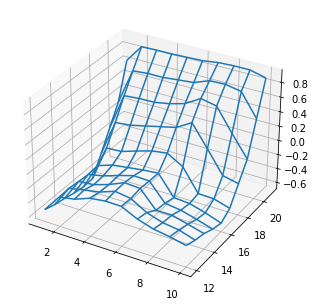

Optimal policy with Usable Ace : (RED : STICK, BLUE : HIT)


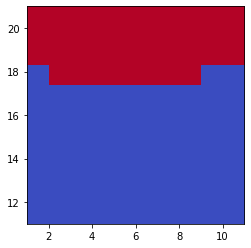

Optimal policy without Usable Ace : (RED : STICK, BLUE : HIT)


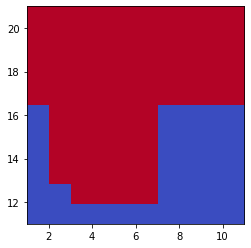

In [26]:
print("Q-value with Usable Ace")
plot_q_val(agent, usable_ace=True)
print("Q-value without Usable Ace")
plot_q_val(agent, usable_ace=False)
print("Optimal policy with Usable Ace : (RED : STICK, BLUE : HIT)")
usable_result = plot_action(agent, usable_ace=True)
print("Optimal policy without Usable Ace : (RED : STICK, BLUE : HIT)")
no_usable_result = plot_action(agent, usable_ace=False)

----
## 9. 과제

### 목표 
위 코드로부터 최적 Policy를 학습시킨 Agent를 사용하여, 블랙잭 게임을 시뮬레이션한 뒤 승률을 계산.

### 초기 설정
 - 플레이어는 1,000,000번의 에피소드로부터 최적 Policy를 학습
 - 플레이어의 초기 자금 : 10,000 달러
 - 플레이어는 게임 참가 시 10 달러를 지불, 결과에 따라 금액을 획득
     - 승리 시 : 20 달러 획득
     - 무승부 시 : 10 달러 획득
     - 패배 시 : 0 달러 획득

### 요구사항
 - 플레이어와 딜러가 1,000번의 게임을 진행
 - 1,000번의 게임 후 플레이어의 승률을 계산
 - 매 게임 별 플레이어의 소지금 변화를 그래프로 시각화

#### * HINT : MonteCarlo 클래스의 generate_episode(), train() 메소드를 참고할 것
----
### (과제 1) 1,000번의 게임 진행

In [30]:
player_money = [10000]
win_rate = 0
pmoney = 10000
count = 0
win = 0
loss = 0
draw = 0
total_win = 0
total_loss = 0
total_draw = 0
result = str()
it = 1000


for i in range(it):
    count += 1
    
    deck.reset()
    dealer.reset()
    agent.reset()
    agent.hit(deck)
    agent.hit(deck)
    dealer.hit(deck)
    dealer.hit(deck)

    done = False    # 에피소드의 종료 여부
    
    while not done:
        # 에피소드가 끝날 때까지 State, Action, Reward를 생성
        sums = agent.calculate_sum()
        if sums < 12:
            agent.hit(deck)
            continue

        state = (sums, bool(agent.usable_ace), dealer.show())
        
        action = agent.policy(state)
        
        done, reward = dealer.observation(action, agent, deck)  # 에피소드 종료 여부, Reward 계산

    if reward == 1:
        win += 1
        pmoney += 10 #10달러 참가비, 20달러 우승비
        player_money.append(player_money[-1]+10)
    elif reward == 0:
        draw += 1
        pmoney += 0 #10달러 참가비,10달러 무승부
        player_money.append(player_money[-1])
    else:
        loss += 1
        pmoney -= 10 #10달러 참가비, 
        player_money.append(player_money[-1]-10)

    if count % 1000 == 0:
        total_win += win
        total_loss += loss
        total_draw += draw

        print("========== Training : Episode ", count, " ===========")
        print("Recent 1000 games win rate :{:.3f}%".format(win / (win + loss) * 100))
        print(" -- 1000 Games WIN :", win, "DRAW :", draw, "LOSS :", loss)
        print("Total win rate : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
        print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)
        print(" -- TOTAL Games Money: ", pmoney)
        
        win_rate = total_win  / (total_win + total_loss) * 100

        win = 0
        loss = 0
        draw = 0

========== Training : Episode  1000  ===========
Recent 1000 games win rate :48.326%
 -- 1000 Games WIN : 433 DRAW : 104 LOSS : 463
Total win rate : 48.326%
 -- TOTAL Games WIN : 433 DRAW : 104 LOSS : 463
 -- TOTAL Games Money:  9700


### (과제 2) 플레이어의 승률을 계산

In [31]:
print('Win Rate: ' + str(win_rate))

Win Rate: 48.325892857142854


### (과제 3) 플레이어의 소지금 변화를 그래프로 시각화

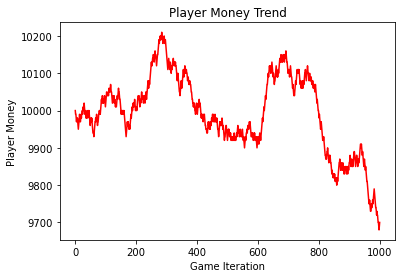

In [32]:
x = list(range(0, 1001))
y = player_money

plt.plot(x, y, 'r')
plt.title('Player Money Trend')
plt.xlabel('Game Iteration')
plt.ylabel('Player Money')

plt.show()

## 추가 과제 : 플레이어의 승률 높이기
State를 수정하여 승률이 더 높은 policy를 찾기

기존 코드의 수정 필요
 - 딜러는 게임이 끝났을 때, 남은 카드의 수를 확인
 - 15장 이상이라면 해당 덱을 다음 게임에서 그대로 사용
 - 15장 미만이라면 52장의 셔플된 새로운 카드를 기존 덱에 추가



---
### 참고자료
[1] Reinforcement Learning - An Introduction (Richard S. Sutton, Andreow G. Barto), 2nd edition, p.120-124 https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf <br>
[2] matplotlib.pyplot.plot Documentation, https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html <br>
[3] matplotlib.pyplot.plot Examples https://matplotlib.org/tutorials/introductory/pyplot.html